In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.image as img 

import cv2 
import itertools 
import pathlib 
import warnings 
from PIL import Image 
from random import randint 
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS 
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras 
from keras import layers 
import tensorflow as tf 
import tensorflow_addons as tfa 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model 
from tensorflow.keras import Sequential, Input 
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.layers import Conv2D, Flatten 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG 
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D 

from distutils.dir_util import copy_tree, remove_tree

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input/alzheimer-mri-dataset/Dataset"))
print("TensorFlow Version: ", tf.__version__)
   

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['Non_Demented', 'Mild_Demented', 'Moderate_Demented', 'Very_Mild_Demented']
TensorFlow Version:  2.6.4


In [2]:
!pip install split_folders 
import splitfolders 
splitfolders.ratio('../input/alzheimer-mri-dataset/Dataset', output = "output", seed = 1345, ratio = (.8, 0.1, 0.1))

Copying files: 6400 files [00:51, 123.33 files/s]


In [3]:
IMG_HEIGHT = 128 
IMG_WIDTH = 128 
train_ds = tf.keras.preprocessing.image_dataset_from_directory("./output/train", seed = 123, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = 64)

test_ds = tf.keras.preprocessing.image_dataset_from_directory("./output/test", seed = 123, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = 64)

val_ds = tf.keras.preprocessing.image_dataset_from_directory("./output/val", seed = 123, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = 64)

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.


2022-09-29 21:13:05.684355: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Found 639 files belonging to 4 classes.


In [4]:
class_names = train_ds.class_names 
print(class_names)
train_ds

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>

2022-09-29 21:13:06.099084: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


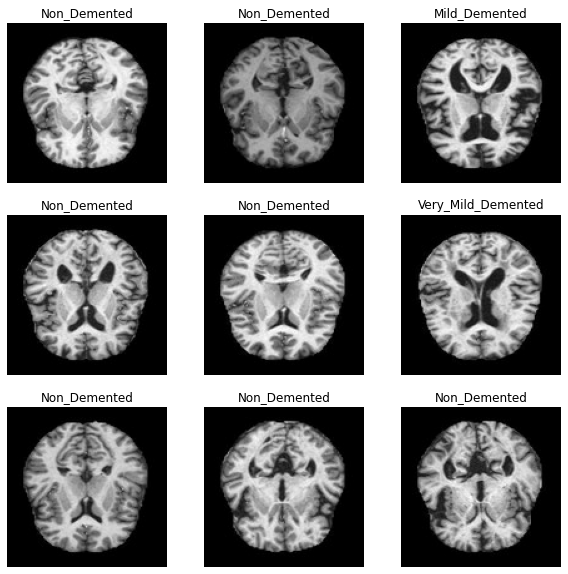

In [5]:
plt.figure(figsize = (10,10)) 
for images, labels in train_ds.take(1): 
    for i in range(9): 
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

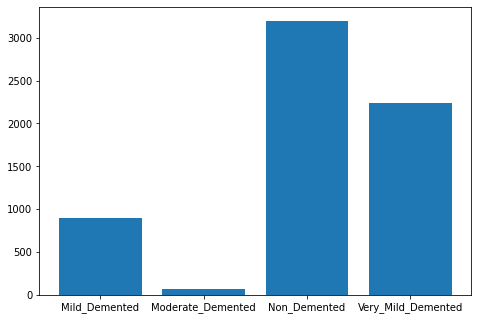

In [6]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
size = [899,64,3200,2240]
ax.bar(class_names, size)
plt.show()

In [7]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [8]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1

In [10]:
hist = model.fit(train_ds, validation_data = val_ds, epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
80/80 [==============================] - 22s 266ms/step - loss: 1.0541 - accuracy: 0.4868 - val_loss: 0.9494 - val_accuracy: 0.6025
Epoch 2/100
80/80 [==============================] - 21s 262ms/step - loss: 0.8897 - accuracy: 0.5767 - val_loss: 0.8281 - val_accuracy: 0.6291
Epoch 3/100
80/80 [==============================] - 21s 260ms/step - loss: 0.7860 - accuracy: 0.6486 - val_loss: 0.6805 - val_accuracy: 0.7136
Epoch 4/100
80/80 [==============================] - 20s 251ms/step - loss: 0.6663 - accuracy: 0.7132 - val_loss: 0.6237 - val_accuracy: 0.7308
Epoch 5/100
80/80 [==============================] - 21s 264ms/step - loss: 0.5084 - accuracy: 0.7875 - val_loss: 0.4233 - val_accuracy: 0.8529
Epoch 6/100
80/80 [==============================] - 21s 261ms/step - loss: 0.4166 - accuracy: 0.8377 - val_loss: 0.3061 - val_accuracy: 0.8873
Epoch 7/100
80/80 [==============================] - 21s 263ms/step - loss: 0.3220 - accuracy: 0.8709 - val_loss: 0.3406 - val_accuracy:

In [11]:
get_ac = hist.history['accuracy']
get_los = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']

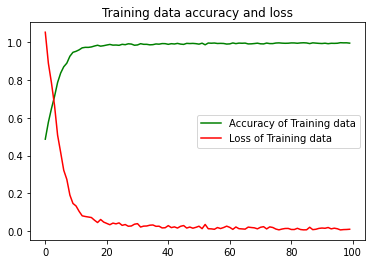

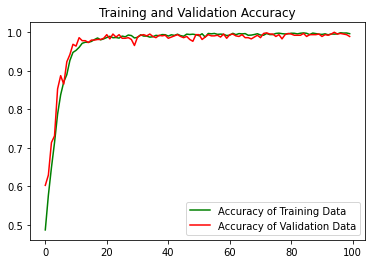

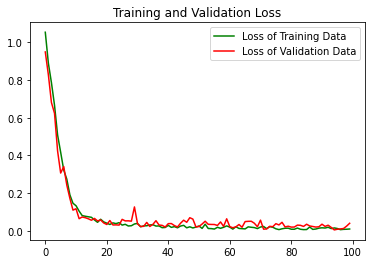

<Figure size 432x288 with 0 Axes>

In [12]:
epochs = range(len(get_ac))
plt.plot(epochs, get_ac, 'g', label = 'Accuracy of Training data')
plt.plot(epochs, get_los, 'r', label = 'Loss of Training data')
plt.title('Training data accuracy and loss')
plt.legend(loc = 0)
plt.figure()

plt.plot(epochs, get_ac, 'g', label = 'Accuracy of Training Data')
plt.plot(epochs, val_acc, 'r', label = 'Accuracy of Validation Data')
plt.title('Training and Validation Accuracy')
plt.legend(loc = 0)
plt.figure()

plt.plot(epochs, get_los, 'g', label = 'Loss of Training Data')
plt.plot(epochs, val_loss, 'r', label = 'Loss of Validation Data')
plt.title('Training and Validation Loss')
plt.legend(loc = 0)
plt.figure()
plt.show()

In [13]:
loss, accuracy = model.evaluate(test_ds)

11/11 [==============================] - 1s 58ms/step - loss: 0.0596 - accuracy: 0.9782


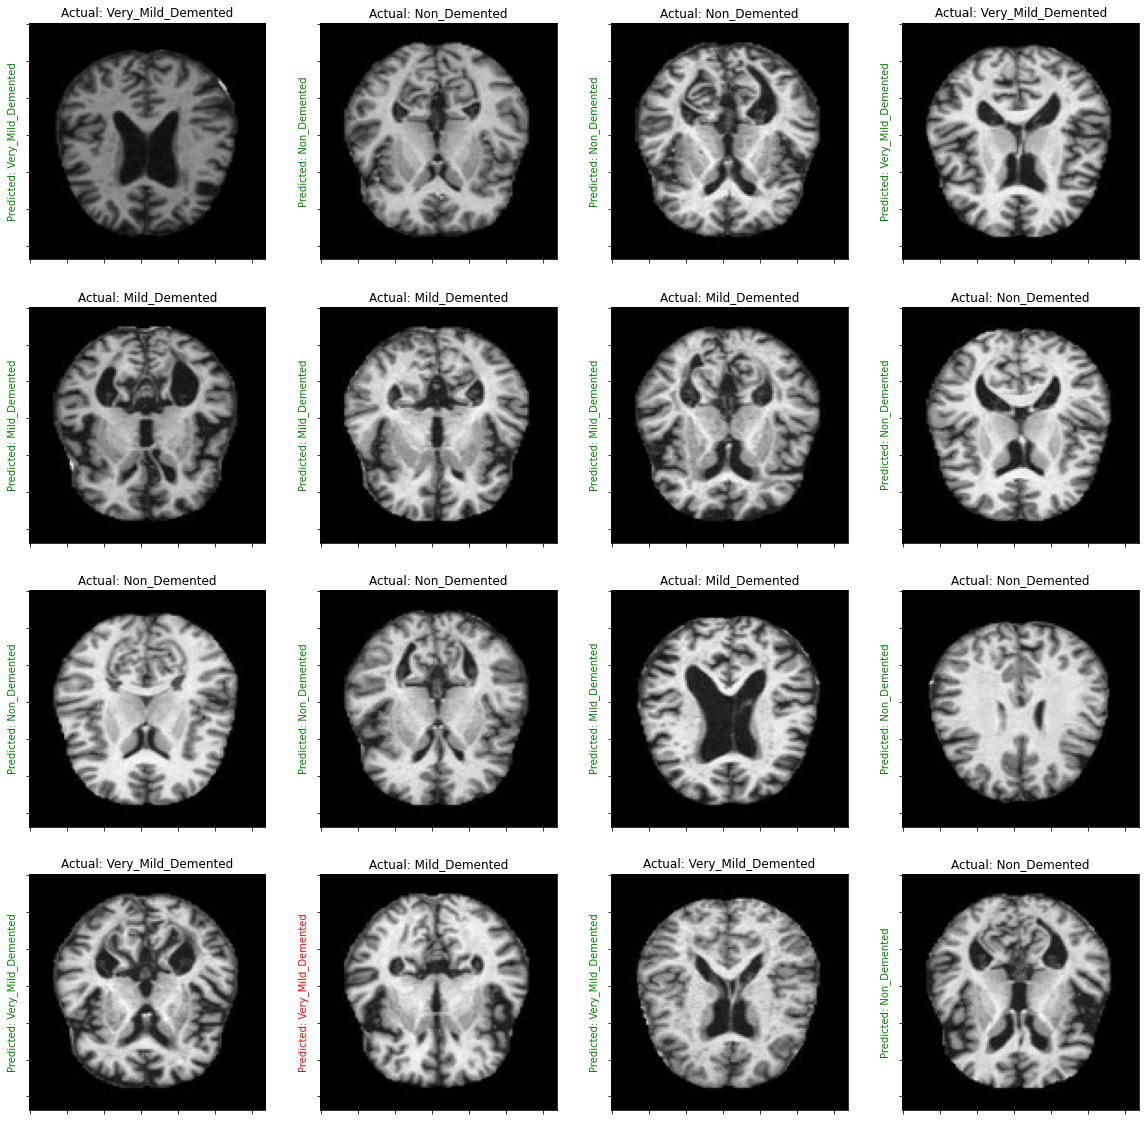

In [15]:
plt.figure(figsize = (20,20))
for images, labels in test_ds.take(1): 
    for i in range(16): 
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[labels[i]] == class_names[np.argmax(score)]): 
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], fontdict = {'color' : 'green'})
            
        else: 
            plt.title("Actual: "+class_names[labels[i]])
            plt.ylabel("Predicted: "+class_names[np.argmax(score)], fontdict = {'color' : 'red'})
        plt.gca().axes.yaxis.set_ticklabels([])
        plt.gca().axes.xaxis.set_ticklabels([])